# Pymeos and Pyspark Partitioning Demo

First we perform the corresponding imports for the libraries to use.

In [1]:
from pymeos import *

from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.serializers import PickleSerializer
import pyspark.sql.functions as F

from pyspark.storagelevel import StorageLevel

from pysparkmeos.partitions.mobilityrdd import PartitionUDTF
from pysparkmeos.partitions.grid.grid_partitioner import GridPartition
from pysparkmeos.partitions.kdtree_partitioner import KDTreePartition
from pysparkmeos.UDT.MeosDatatype import *
from pysparkmeos.utils.udt_appender import udt_append
from pysparkmeos.utils.utils import *
from pysparkmeos.UDF.udf import *

from typing import *

import random, datetime

from datetime import timedelta
from functools import partial
from datetime import datetime, timezone
import contextily as cx
import distinctipy
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import shapely.geometry as shp
from pymeos.plotters import (
    TemporalPointSequenceSetPlotter,
    TemporalPointSequencePlotter,
)

import matplotlib.pyplot as plt
import numpy as np
import os, sys
from shapely import wkb, box
import pandas as pd
from functools import reduce

## Initialize Pymeos and setup Pyspark

In [2]:
# Initialize PyMEOS
pymeos_initialize("UTC")

os.environ['PYSPARK_DRIVER_PYTHON_OPTS']= "notebook"
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
os.environ['PYSPARK_PYTHON'] = sys.executable

# Initialize a Spark session
spark = SparkSession.builder \
    .appName("PySpark UDF Example with PyMEOS") \
    .master("local[3]") \
    .config("spark.default.parallelism", 3) \
    .config("spark.executor.memory", "3g") \
    .config("spark.executor.cores", 1) \
    .config("spark.driver.memory", "2g") \
    .config("spark.driver.maxResultSize", 0) \
    .config("spark.sql.allowMultipleTableArguments.enabled", True) \
    .getOrCreate()

#spark.sparkContext.setLogLevel("DEBUG")

# Append the UDT mapping to the PyMEOS classes
udt_append()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/05 08:59:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 33500)
Traceback (most recent call last):
  File "/usr/lib/python3.9/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.9/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.9/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.9/socketserver.py", line 720, in __init__
    self.handle()
  File "/usr/local/lib/python3.9/dist-packages/pyspark/accumulators.py", line 295, in handle
    poll(ac

## Read the DataFrame and create the columns of Pymeos data objects

First, we are going to read a dataset from OpenSky, this dataset cointains the trajectory information of multiple flights within a timeframe.  

Using the latitude, longitude and timestamp we can create a PyMEOS TGeogPointInst, that in PySpark will be wrapped into a TGeogPointInstUDT object.

In [3]:
# Read data from a CSV file
#data_path = "../../small_mid_states_2022-06-27-00.csv"  # Update this with your CSV file path
data_path = "../../sample.csv"

df = spark.read.csv(
    data_path, 
    header=True, 
    inferSchema=True, 
    mode='PERMISSIVE'
).select("icao24", "time", "lat", "lon")

# Clean nans, if not Points can't be created
df = df.dropna(subset=["lat", "lon", "time", "icao24"])

# Convert the 'time' column to the correct format
df = df \
    .withColumn("time", F.from_unixtime(F.col("time"), "yyyy-MM-dd' 'HH:mm:ss")) \
    .withColumn("lat", F.round("lat", 2)) \
    .withColumn("lon", F.round("lon", 2)) \
    .withColumn("Point", create_point_udf("lat", "lon", "time")) \
    .withColumn("x", get_point_x("Point")) \
    .withColumn("y", get_point_y("Point")) \
    .withColumn("t", get_point_timestamp("Point")) \
    .withColumn("id", F.monotonically_increasing_id())

df.show(3)

24/06/05 08:59:20 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


+------+-------------------+------+-----+--------------------+-----+------+-------------------+---+
|icao24|               time|   lat|  lon|               Point|    x|     y|                  t| id|
+------+-------------------+------+-----+--------------------+-----+------+-------------------+---+
|a00529|2022-06-27 00:00:10| 28.73|-81.5|POINT(-81.5 28.73...|-81.5| 28.73|2022-06-27 00:00:10|  0|
|a00529|2022-06-27 00:00:55|-25.02|120.0|POINT(120 -25.02)...|120.0|-25.02|2022-06-27 00:00:55|  1|
|a00529|2022-06-27 00:00:58|  80.0| 10.0|POINT(10 80)@2022...| 10.0|  80.0|2022-06-27 00:00:58|  2|
+------+-------------------+------+-----+--------------------+-----+------+-------------------+---+
only showing top 3 rows



Handling a dataset like this gives us granularity over the datapoints, but it would be better to group the trajectories together using another function, this will return the TGeogPointSeq objects representing each trajectory. Let's create a UDTF that takes the icao24, and Point, and creates a new table with icao24, and PointSeq.

In [4]:
print("Total row Point count: ", df.count())

df.groupBy("icao24").agg(F.count("Point").alias("cnt")).orderBy("cnt",ascending=False).show()

trajectories = df.groupBy("icao24").agg(
    F.collect_list(F.col("Point")).alias("PointSeq")
).select("icao24", "PointSeq").withColumn("PointSeq", tgeompointseq_from_instant_list("PointSeq"))


print("Total row PointSeq count after processing: ", trajectories.count())

trajectories.show(5)

Total row Point count:  6


+------+---+
|icao24|cnt|
+------+---+
|a00528|  3|
|a00529|  3|
+------+---+

Total row PointSeq count after processing:  2


+------+--------------------+
|icao24|            PointSeq|
+------+--------------------+
|a00528|[POINT(-75.5 0)@2...|
|a00529|[POINT(-81.5 28.7...|
+------+--------------------+



This has reduced the table from individual Points to much less sequences PointSeq!

Now we need to calculate the boundaries of the whole space of trajectories.

In [5]:
trajectories = trajectories.withColumn("STBox", point_to_stbox("PointSeq")).withColumn("seqId", F.monotonically_increasing_id())
trajectories.createOrReplaceTempView("trajectories")
trajectories.show()
trajectories.cache()
print(trajectories.count())

+------+--------------------+--------------------+-----+
|icao24|            PointSeq|               STBox|seqId|
+------+--------------------+--------------------+-----+
|a00528|[POINT(-75.5 0)@2...|STBOX XT(((-75.5,...|    0|
|a00529|[POINT(-81.5 28.7...|STBOX XT(((-81.5,...|    1|
+------+--------------------+--------------------+-----+



2


In [6]:
# We use the helper functions from utils to mapReduce the bounds of the whole dataset.
bounds = trajectories.rdd.mapPartitions(bounds_calculate_map).reduce(bounds_calculate_reduce)
bounds

STBoxWrap(STBOX XT(((-81.5,-25.02),(120,80)),[2022-06-27 00:00:10+00, 2022-06-27 00:00:58+00)))

## Generate the partitioning scheme and repartition data

/tmp/ipykernel_38304/2453290281.py:3: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
24/06/05 09:31:40 WARN CacheManager: Asked to cache already cached data.


Regular Grid Partitioning PySpark Table


+------+--------------------+
|tileid|                tile|
+------+--------------------+
|     0|STBOX XT(((-91.5,...|
|     1|STBOX XT(((-91.5,...|
|     2|STBOX XT(((-91.5,...|
|     3|STBOX XT(((-91.5,...|
|     4|STBOX XT(((-91.5,...|
|     5|STBOX XT(((-91.5,...|
|     6|STBOX XT(((-91.5,...|
|     7|STBOX XT(((-91.5,...|
|     8|STBOX XT(((-91.5,...|
|     9|STBOX XT(((-17.66...|
|    10|STBOX XT(((-17.66...|
|    11|STBOX XT(((-17.66...|
|    12|STBOX XT(((-17.66...|
|    13|STBOX XT(((-17.66...|
|    14|STBOX XT(((-17.66...|
|    15|STBOX XT(((-17.66...|
|    16|STBOX XT(((-17.66...|
|    17|STBOX XT(((-17.66...|
|    18|STBOX XT(((56.166...|
|    19|STBOX XT(((56.166...|
+------+--------------------+
only showing top 20 rows



24/06/05 09:31:48 WARN CacheManager: Asked to cache already cached data.        


KD Tree Partitioning PySpark Table
+------+--------------------+
|tileid|                tile|
+------+--------------------+
|     0|STBOX XT(((-91.5,...|
|     1|STBOX XT(((-91.5,...|
|     2|STBOX XT(((-5.5,2...|
|     3|STBOX XT(((10,-35...|
|     4|STBOX XT(((10,25....|
|     5|STBOX XT(((12.5,2...|
+------+--------------------+



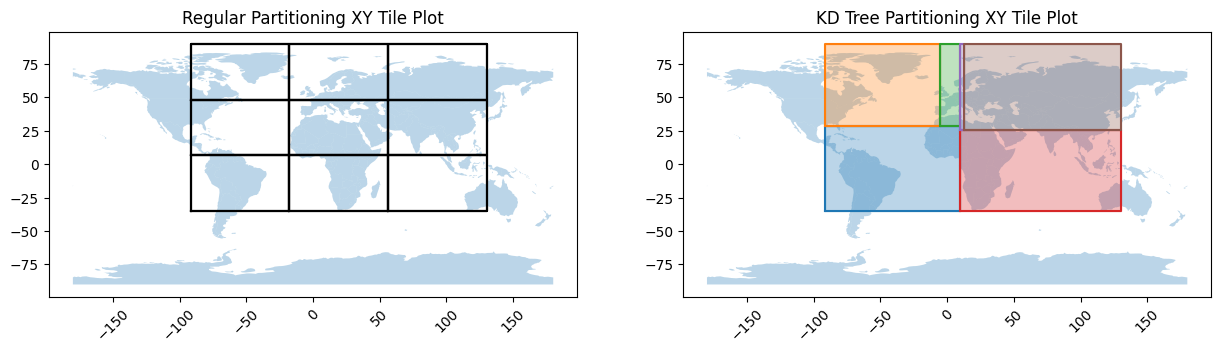

In [31]:
# Now we calculate the grid and partition accordingly
fig, ax = plt.subplots(1, 2, figsize=(15, 10))
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(ax=ax[1], alpha=0.3)
world.plot(ax=ax[0], alpha=0.3)

# Regular Grid
gp = GridPartition(cells_per_side=3, bounds=bounds.expand(10.0))
grid = gp.as_spark_table()
grid.cache()
print("Regular Grid Partitioning PySpark Table")
grid.show()
grid.createOrReplaceTempView("grid")
gp.plot(axes=ax[0], color='black', draw_filling=False)
ax[0].title.set_text("Regular Partitioning XY Tile Plot")

# KDTree
pointsample = [traj.PointSeq for traj in trajectories.select('PointSeq').collect()] #  Take real sample if datasize is too big
gpkd = KDTreePartition(movingObjects=pointsample, dimensions=['x', 'y'], bounds=bounds.expand(10.0), max_depth=3)
gridkd = gpkd.as_spark_table()
gridkd.cache()
print("KD Tree Partitioning PySpark Table")
gridkd.show()
gridkd.createOrReplaceTempView("gridkd")
gpkd.plot(axes=ax[1])
ax[1].title.set_text("KD Tree Partitioning XY Tile Plot")

In [38]:
%time

# Register the UDTF on the spark session
spark.udtf.register("PartitionUDTF", PartitionUDTF)

def map_partition_rdd(index, rows):
    for row in rows:
        yield (row['tileid'], row)

def partition_trajectories(spark, gridname, gridclass):
    trajectoriesPartMap = spark.sql(f"""
        SELECT * 
        FROM PartitionUDTF(
            TABLE(
                    SELECT 
                        seqId AS trajectory_id, 
                        PointSeq AS trajectory, 
                        (SELECT collect_list(tile) FROM {gridname}) AS tiles, 
                        (SELECT collect_list(tileid) FROM {gridname}) AS tileids
                    FROM trajectories
            )
        )
    """)
    num_partitions = gridclass.num_partitions()
    trajectoriesPartMapRdd = trajectoriesPartMap.rdd.mapPartitionsWithIndex(map_partition_rdd).partitionBy(num_partitions)
    trajectoriesPartMap = trajectoriesPartMapRdd.toDF(["partitionKey", "trajectorydata"]).withColumn("trajectory", F.col("trajectorydata.movingobject")).withColumn("trajectoryId", F.col("trajectorydata.movingobjectid")).drop("trajectorydata")
    trajectoriesPartMap.orderBy("trajectoryId").cache()
    print(f"{gridname} Partitioned Trajectories.")
    trajectoriesPartMap.show()
    return trajectoriesPartMap, trajectoriesPartMapRdd, gridclass, gridname
    
partMaps = [partition_trajectories(spark, gridname, gridclass) for gridname, gridclass in zip(['grid', 'gridkd'], [gp, gpkd])]

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 17.6 µs


24/06/05 09:47:25 WARN SimpleTableFunctionRegistry: The function partitionudtf replaced a previously registered function.


grid Partitioned Trajectories.
+------------+--------------------+-------------+
|partitionKey|          trajectory| trajectoryId|
+------------+--------------------+-------------+
|           0|{[POINT(-75.5 0)@...| 326417514496|
|           3|{[POINT(-63.15288...| 326417514496|
|           3|{[POINT(-81.5 28....|1005022347264|
|          10|{[POINT(1.2618263...|1005022347264|
|          12|{[POINT(-17.66667...| 326417514496|
|          12|{[POINT(-17.66666...|1005022347264|
|          13|{[POINT(5.3000000...| 326417514496|
|          13|{[POINT(-9.855555...|1005022347264|
|          14|{[POINT(56.16667 ...|1005022347264|
|          17|{[POINT(43.175303...|1005022347264|
|          19|{[POINT(56.166662...|1005022347264|
|          20|{[POINT(61.788888...|1005022347264|
|          23|{[POINT(86.824733...|1005022347264|
+------------+--------------------+-------------+



gridkd Partitioned Trajectories.
+------------+--------------------+-------------+
|partitionKey|          trajectory| trajectoryId|
+------------+--------------------+-------------+
|           0|{[POINT(-75.5 0)@...| 326417514496|
|           0|{[POINT(-81.5 28....|1005022347264|
|           1|{[POINT(-22.18346...| 326417514496|
|           1|{[POINT(-81.5 28....|1005022347264|
|           2|{[POINT(-5.5 37.7...| 326417514496|
|           2|{[POINT(10 80)@20...|1005022347264|
|           3|{[POINT(12.5 25.7...| 326417514496|
|           3|{[POINT(9.9999992...|1005022347264|
|           4|{[POINT(9.9999998...| 326417514496|
|           4|{[POINT(12.500006...|1005022347264|
|           5|{[POINT(12.5 25.7...| 326417514496|
|           5|{[POINT(66.85394 ...|1005022347264|
+------------+--------------------+-------------+



## Show the partition distribution

In [41]:
%%time

for trajectoriesPartMap, _, _, gridname in partMaps:
    print(f"{gridname} partition distribution.")
    trajectoriesPartMap.groupBy("partitionKey").count().show()
    trajectoriesPartRdd = trajectoriesPartMap.rdd
    print(trajectoriesPartRdd.getNumPartitions())
    
    # Function to count rows per partition
    def count_in_partition(idx, iterator):
        cnt = 0
        for _ in iterator:
            cnt += 1
        return [(idx, cnt)]
    
    # Using mapPartitionsWithIndex to count rows per partition
    partition_counts = trajectoriesPartRdd.mapPartitionsWithIndex(count_in_partition).collect()
        
    # Print the results
    for partition_id, cnt in partition_counts:
        print(f"Partition {partition_id} has {cnt} rows")
    
    trajectoriesPartMap.show()

grid partition distribution.


+------------+-----+
|partitionKey|count|
+------------+-----+
|           0|    1|
|           3|    2|
|          10|    1|
|          12|    2|
|          13|    2|
|          14|    1|
|          17|    1|
|          19|    1|
|          20|    1|
|          23|    1|
+------------+-----+

27


Partition 0 has 1 rows
Partition 1 has 0 rows
Partition 2 has 0 rows
Partition 3 has 2 rows
Partition 4 has 0 rows
Partition 5 has 0 rows
Partition 6 has 0 rows
Partition 7 has 0 rows
Partition 8 has 0 rows
Partition 9 has 0 rows
Partition 10 has 1 rows
Partition 11 has 0 rows
Partition 12 has 2 rows
Partition 13 has 2 rows
Partition 14 has 1 rows
Partition 15 has 0 rows
Partition 16 has 0 rows
Partition 17 has 1 rows
Partition 18 has 0 rows
Partition 19 has 1 rows
Partition 20 has 1 rows
Partition 21 has 0 rows
Partition 22 has 0 rows
Partition 23 has 1 rows
Partition 24 has 0 rows
Partition 25 has 0 rows
Partition 26 has 0 rows
+------------+--------------------+-------------+
|partitionKey|          trajectory| trajectoryId|
+------------+--------------------+-------------+
|           0|{[POINT(-75.5 0)@...| 326417514496|
|           3|{[POINT(-63.15288...| 326417514496|
|           3|{[POINT(-81.5 28....|1005022347264|
|          10|{[POINT(1.2618263...|1005022347264|
|          1

## Plot the Projection of the grid and the distribution of data

/tmp/ipykernel_38304/3013110254.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


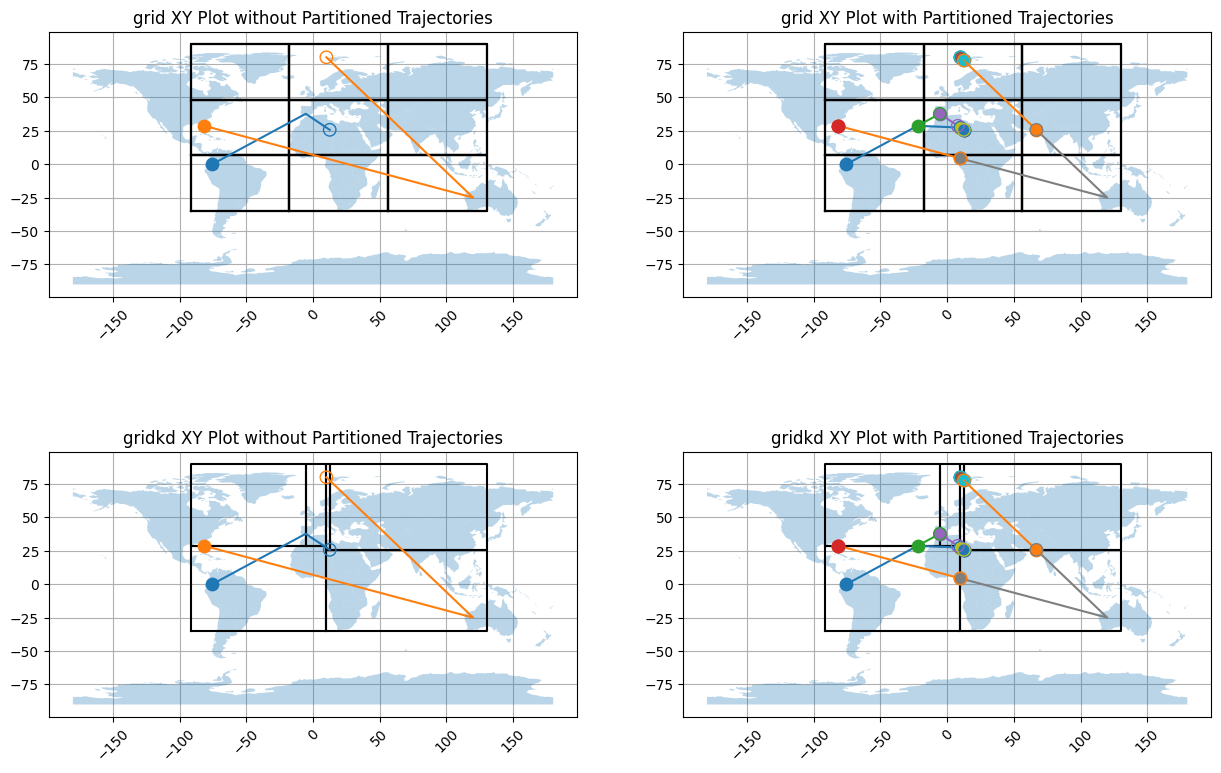

In [47]:
fig, ax = plt.subplots(len(partMaps), 2, figsize=(15, 10))
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

for i, (trajectoriesMap, partMapRdd, gridclass, gridname) in enumerate(partMaps):
    world.plot(ax=ax[i][1], alpha=0.3)
    world.plot(ax=ax[i][0], alpha=0.3)

    gridclass.plot(axes=ax[i][0], color='black', draw_filling=False)
    gridclass.plot(axes=ax[i][1], color='black', draw_filling=False)

    colors = plt.cm.Accent(np.linspace(0, 1, len(gridclass.tilesstr)))
    # Adding an alpha value when creating the color map
    alpha_value = 1.0
    color_map = {i: colors[i][:3].tolist() + [alpha_value] for i, _ in enumerate(gridclass.tilesstr)}
    trajectory_colors = ['red', 'green', 'blue', 'yellow', 'orange', 'pink', 'lightgreen', 'darkblue']

    trajectory_idx = {}
    for idx, row in enumerate(trajectoriesPartMap.limit(1000).toLocalIterator()):
        if row.trajectoryId in trajectory_idx:
            c = trajectory_idx[row.trajectoryId]
        else:
            c = idx
            trajectory_idx[row.trajectoryId] = idx
        traj = row.trajectory
        TemporalPointSequenceSetPlotter.plot_xy(
            traj, axes=ax[i][1], show_markers=True, show_grid=True 
        )

    for idx, row in enumerate(trajectories.limit(1000*gridclass.num_partitions()).toLocalIterator()):
        if row.icao24 in trajectory_idx:
            c = trajectory_idx[row.icao24]
        else:
            c = idx
            trajectory_idx[row.icao24] = idx
        TemporalPointSequencePlotter.plot_xy(
            row.PointSeq, axes=ax[i][0], show_markers=True, show_grid=True 
        )

    ax[i][0].title.set_text(f"{gridname} XY Plot without Partitioned Trajectories")
    ax[i][1].title.set_text(f"{gridname} XY Plot with Partitioned Trajectories")